In [3]:
#-------------Importamos las librerías necesarias-------------
import numpy as np
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import copernicusmarine
import os
import glob
from datetime import datetime, timedelta, date
from IPython.display import clear_output

clear_output()

In [2]:
#------- Eliminamos archivos anteriores de formato NetCDF----------------
#Se eliminan los NetCDF anteriores para optimizar espacio en el disco
def eliminar_archivos_nc():
    """
    Elimina todos los archivos con la extensión .nc en la misma carpeta del script.
    """
    extension = ".nc"
    patron = f"*{extension}"
    archivos_a_eliminar = glob.glob(patron)

    if not archivos_a_eliminar:
        return

    for nombre_archivo in archivos_a_eliminar:
        try:
            os.remove(nombre_archivo)
        except Exception as e:
            print(f"Ocurrió un error al eliminar {nombre_archivo}: {e}")

eliminar_archivos_nc()

In [3]:
#------- Descargamos los datos de interes----------------
#Usando API de copernicus para descargar informacion
# Datos mensuales desde el 1993 al 2021
copernicusmarine.subset(
  dataset_id="cmems_mod_glo_phy_my_0.083deg_P1M-m",
  dataset_version="202311",
  variables=["so", "thetao"],
  minimum_longitude=-90,
  maximum_longitude=-80,
  minimum_latitude=-10,
  maximum_latitude=0,
  start_datetime="1993-01-01T00:00:00",
  end_datetime="2021-06-30T00:00:00",
  minimum_depth=0.49402499198913574,
  maximum_depth=541.0889282226562,
  netcdf_compression_level=1,
  disable_progress_bar=True,
  output_filename="Archivo_TS1.nc"
)

# Datos mensuales desde el 2021 al 2025
copernicusmarine.subset(
  dataset_id="cmems_mod_glo_phy_myint_0.083deg_P1M-m",
  dataset_version="202311",
  variables=["so", "thetao"],
  minimum_longitude=-90,
  maximum_longitude=-80,
  minimum_latitude=-10,
  maximum_latitude=0,
  start_datetime="2021-07-01T00:00:00",
  end_datetime="2025-07-01T00:00:00",
  minimum_depth=0.49402499198913574,
  maximum_depth=541.0889282226562,
  netcdf_compression_level=1,
  disable_progress_bar=True,
  output_filename="Archivo_TS2.nc"
)

clear_output()

In [4]:
#------- Combinacion de archivos segun fechas----------------
ds1 = xr.open_dataset('Archivo_TS1.nc') # Archivo de 1993 a 2021
ds2 = xr.open_dataset('Archivo_TS2.nc') # Archivo de 2021 a 2025

# Concatenar los datasets a lo largo de la dimensión de time
ds_combinado = xr.concat([ds1, ds2], dim='time')
ds_combinado.to_netcdf('TScombinado.nc')



In [5]:
#-------Desarrollamos las climatologias----------------
# Los resultados (ds_climatologia) tendrán una nueva dimensión 'month' de 1 a 12.
ds_climatologia = ds_combinado.groupby('time.month').mean(skipna=True)

# Seleccionamos el primer nivel de profundidad, que es el más superficial.
# Usamos .isel(depth=0) para seleccionar el primer índice de la dimensión 'depth'.
ds_superficie_clima = ds_climatologia.isel(depth=0)

# Para un corte vertical, promediamos a lo largo de la latitud ('latitude') y longitud ('longitude').
# Esto nos da un promedio espacial para cada mes y profundidad.
ds_corte_clima = ds_climatologia[['thetao', 'so']].mean(dim=['latitude', 'longitude'], skipna=True)


# Climatología de la Región Niño 1+2

## Temperatura y Salinidad Superficial del Mar en la Región Niño 1+2
    La Región Niño 1+2 es el area del Océano Pacífico oriental ubicada entre los 0° y 10° de latitud Sur y desde la costa de Sudamérica (Ecuador y Perú) hasta los 90° de longitud Oeste. Es la región más cercana a la costa y la primera en mostrar las señales del fenómeno de El Niño.
### Importancia en la Región Niño 1+2
    Conocer la TSM y la SSM en esta región es crucial por varias razones:
    •	Indicador de El Niño-Oscilación del Sur (ENOS): El calentamiento anómalo de la TSM en la región Niño 1+2 es el principal indicador del inicio de un evento El Niño. Este calentamiento altera los patrones de lluvia, causando intensas precipitaciones e inundaciones en las costas de Ecuador y Perú.
    •	Impacto en la Pesca: Las aguas de esta región son naturalmente frías y ricas en nutrientes gracias al afloramiento costero (corriente de Humboldt). Un aumento en la TSM debilita este afloramiento, disminuyendo la disponibilidad de nutrientes y, por ende, el plancton. Esto provoca la migración o muerte de especies de peces de agua fría, como la anchoveta, que es fundamental para la economía pesquera de ambos países.
    •	Influencia Climática: La TSM influye directamente en la temperatura del aire y la humedad. Aguas más cálidas transfieren más calor y vapor de agua a la atmósfera, generando inestabilidad climática y eventos extremos.
    Conocer la climatología vertical (cómo cambian la temperatura y la salinidad con la profundidad) permite entender la estructura del océano. Ayuda a predecir la intensidad del afloramiento, la profundidad a la que se encuentran los nutrientes y la disponibilidad de hábitats para diferentes especies marinas.
________________________________________
## El Frente Ecuatorial
    Es la zona de convergencia donde se encuentran dos masas de agua con características distintas:
    1.	Las aguas frías y más salinas de la corriente de Humboldt que fluyen hacia el norte desde la costa de Perú.
    2.	Las aguas cálidas y menos salinas provenientes de la zona ecuatorial y del oeste del Pacífico.
    Esta convergencia crea un "muro" o gradiente horizontal muy marcado de temperatura y salinidad.
## Influencia para Ecuador y Perú
    •	Barrera Biológica: Actúa como una barrera natural que separa ecosistemas marinos. Al sur del frente predominan especies de aguas frías, mientras que al norte se encuentran especies de aguas tropicales.
    •	Regulador Climático: La posición y la intensidad de este frente determinan la extensión de las aguas cálidas hacia el sur. Durante un evento El Niño, el frente se debilita y se desplaza mucho más al sur, permitiendo que las aguas cálidas invadan la costa peruana, intensificando las lluvias y los impactos negativos en la pesca.
    •	Zona de Alta Productividad: La convergencia de aguas favorece la concentración de nutrientes y plancton, convirtiendo la zona del frente en un área de alta productividad biológica y, por tanto, de gran importancia para la pesca.
________________________________________
## Importancia de la Termoclina y la Haloclina
    La termoclina es la capa dentro del océano donde la temperatura disminuye bruscamente con la profundidad. La haloclina es la capa donde la salinidad cambia rápidamente. Ambas capas separan las aguas superficiales, más cálidas y mezcladas, de las aguas profundas, más frías y densas.
### Relevancia en la Región Niño 1+2 para Ecuador y Perú
    •	Profundidad y Nutrientes: La profundidad de la termoclina es un indicador clave de la salud del ecosistema. En condiciones normales, la termoclina en esta región es poco profunda, lo que permite que el afloramiento costero traiga fácilmente nutrientes desde las aguas profundas a la superficie, fertilizando el mar.
    •	Impacto de El Niño: Durante un evento El Niño, un pulso de agua caliente (onda Kelvin) desde el Pacífico occidental llega a las costas de Ecuador y Perú, provocando que la termoclina se hunda. Al estar más profunda, el viento del afloramiento no tiene la fuerza suficiente para levantar los nutrientes a la superficie. Esto "esteriliza" las aguas superficiales, colapsando la base de la cadena alimenticia y afectando directamente a la pesca.
    •	Pronóstico y Monitoreo: Monitorear la profundidad de la termoclina y la haloclina es fundamental para pronosticar la intensidad y duración de un evento El Niño. Un hundimiento pronunciado y sostenido de estas capas es una señal inequívoca de que el fenómeno está en pleno desarrollo y que sus impactos socioeconómicos serán severos para ambos países.


In [6]:
#------- Aperturamos los archivos para ordenar segun longitud y latitud----------------
ds1 = xr.open_dataset('Archivo_TS1.nc')
ds2 = xr.open_dataset('Archivo_TS2.nc')
ds_combinado = xr.open_dataset('TScombinado.nc')

#Ordenar coordenadas y calcular climatología
ds_combinado_ordenado = ds_combinado.sortby(['longitude', 'latitude'])

ds_climatologia = ds_combinado_ordenado.groupby('time.month').mean(skipna=True)
ds_superficie_clima = ds_climatologia.isel(depth=0)
ds_corte_clima = ds_climatologia[['thetao', 'so']].mean(dim=['latitude', 'longitude'], skipna=True)



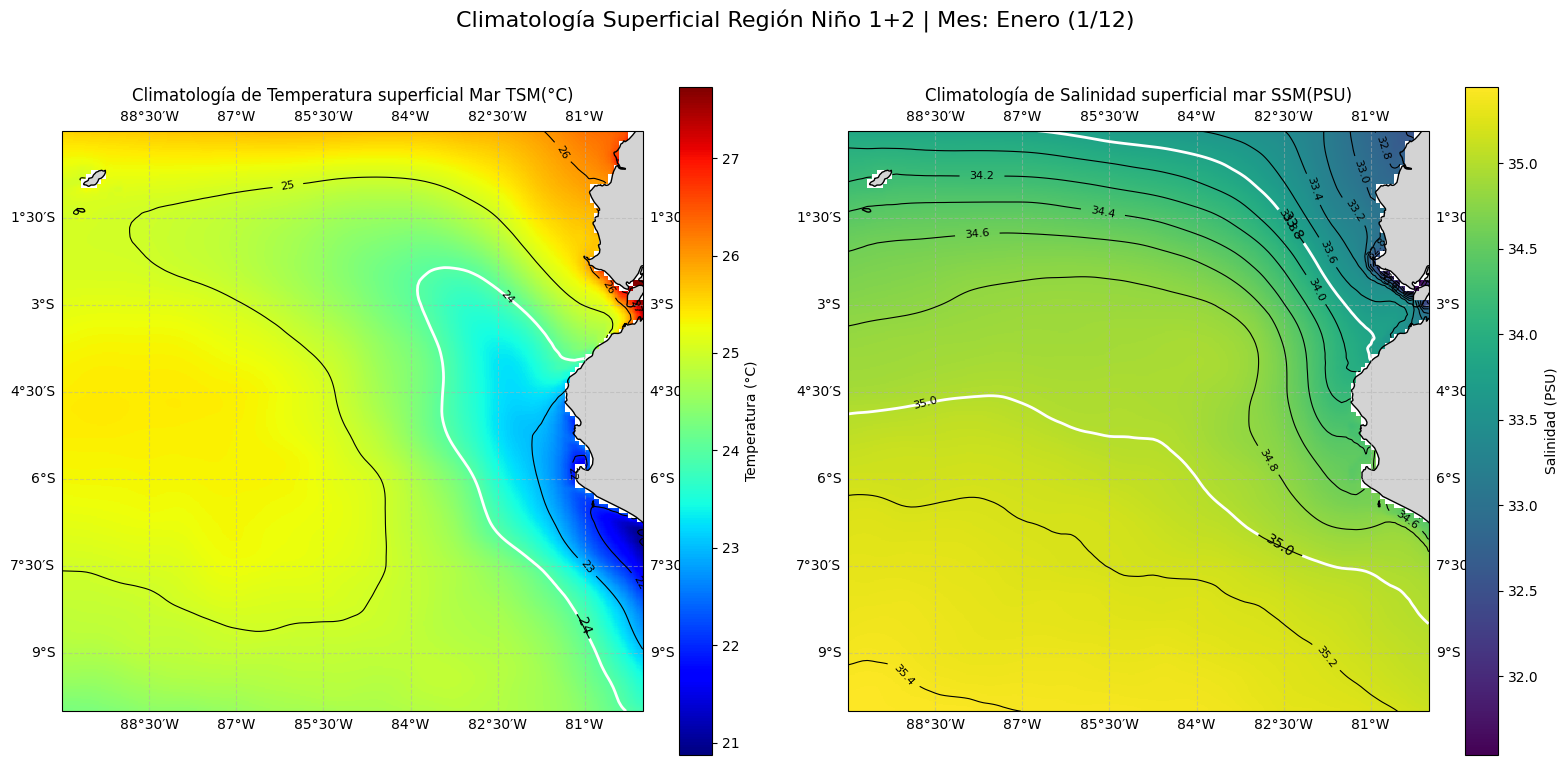

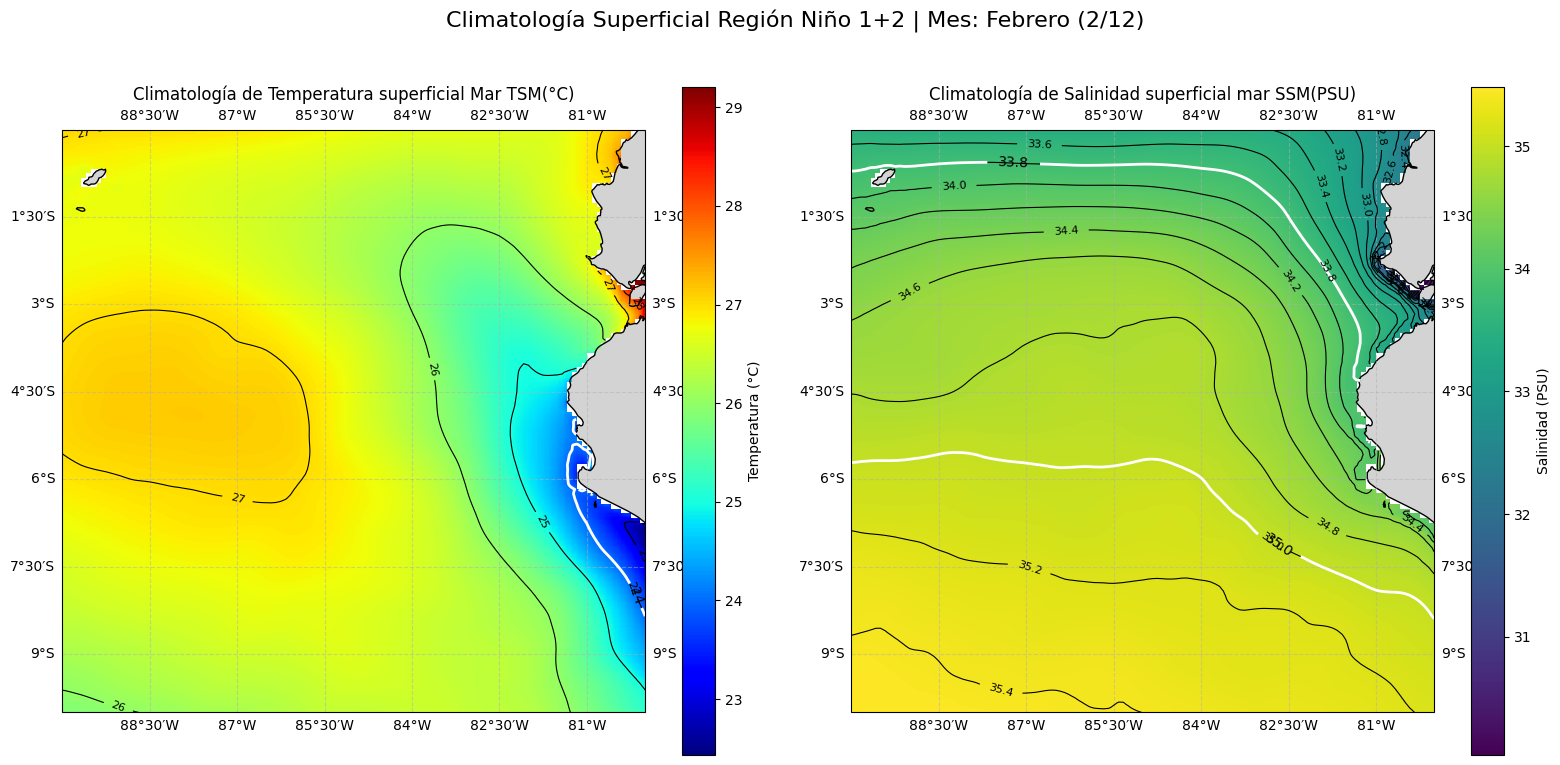

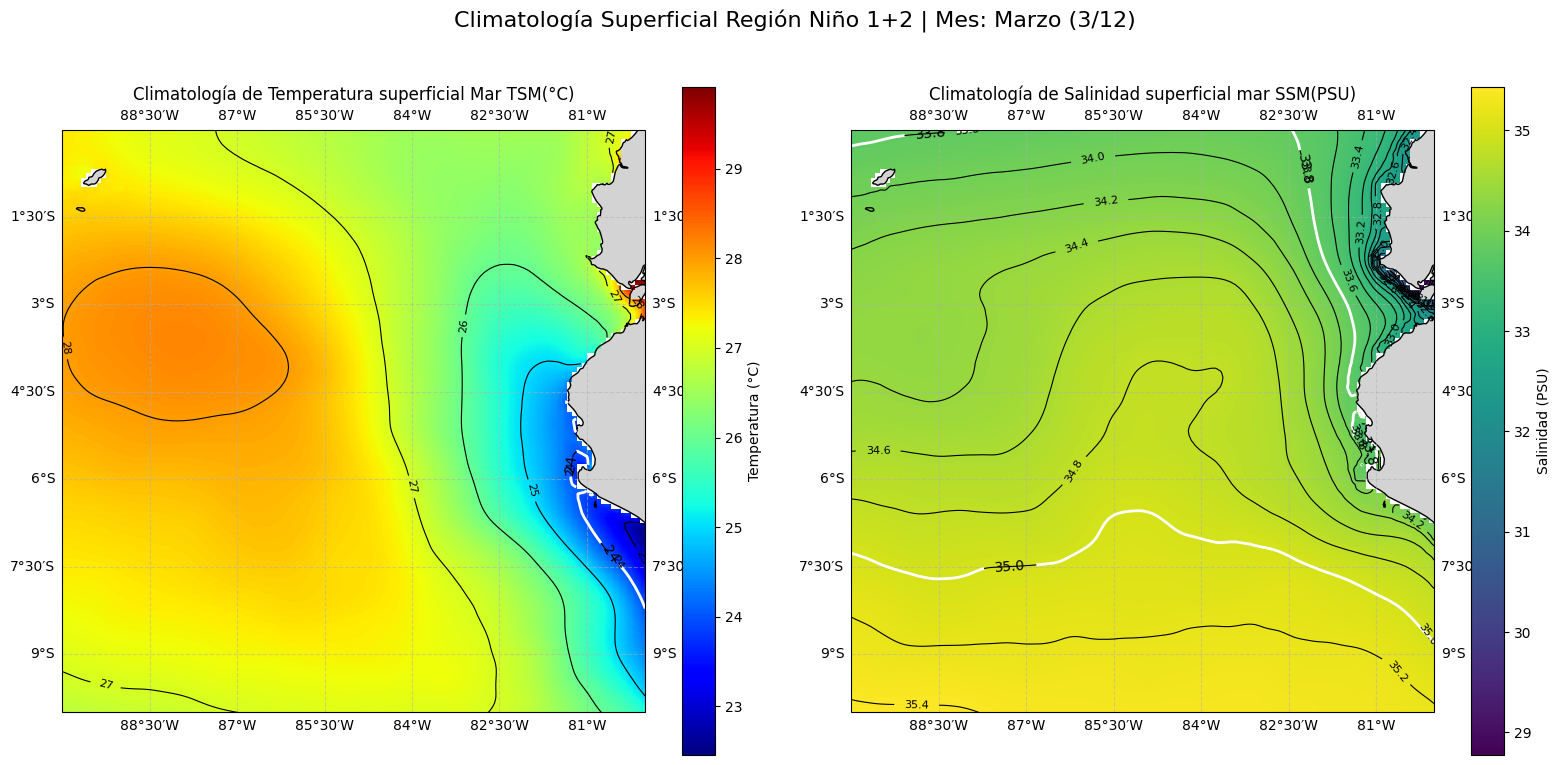

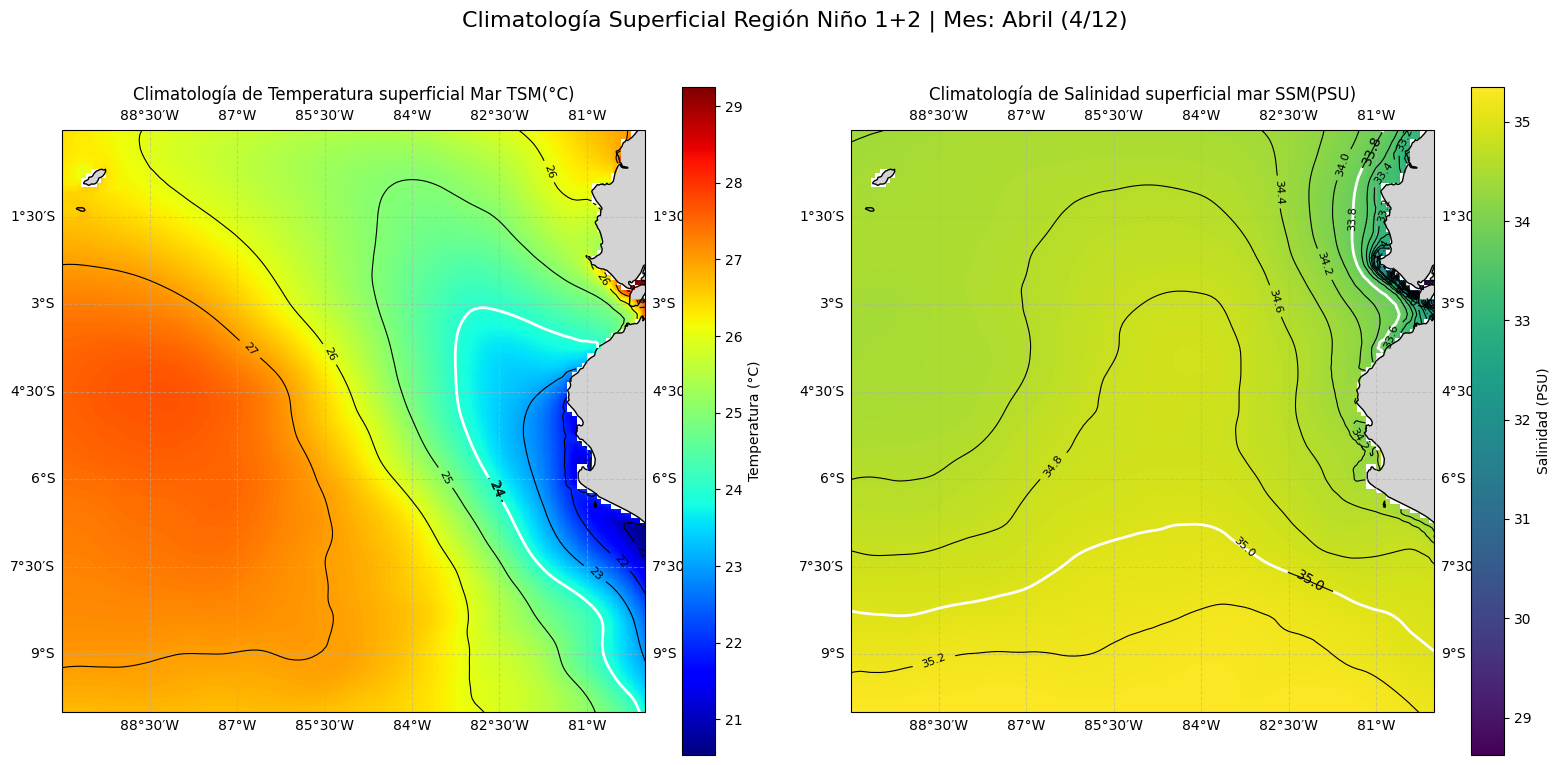

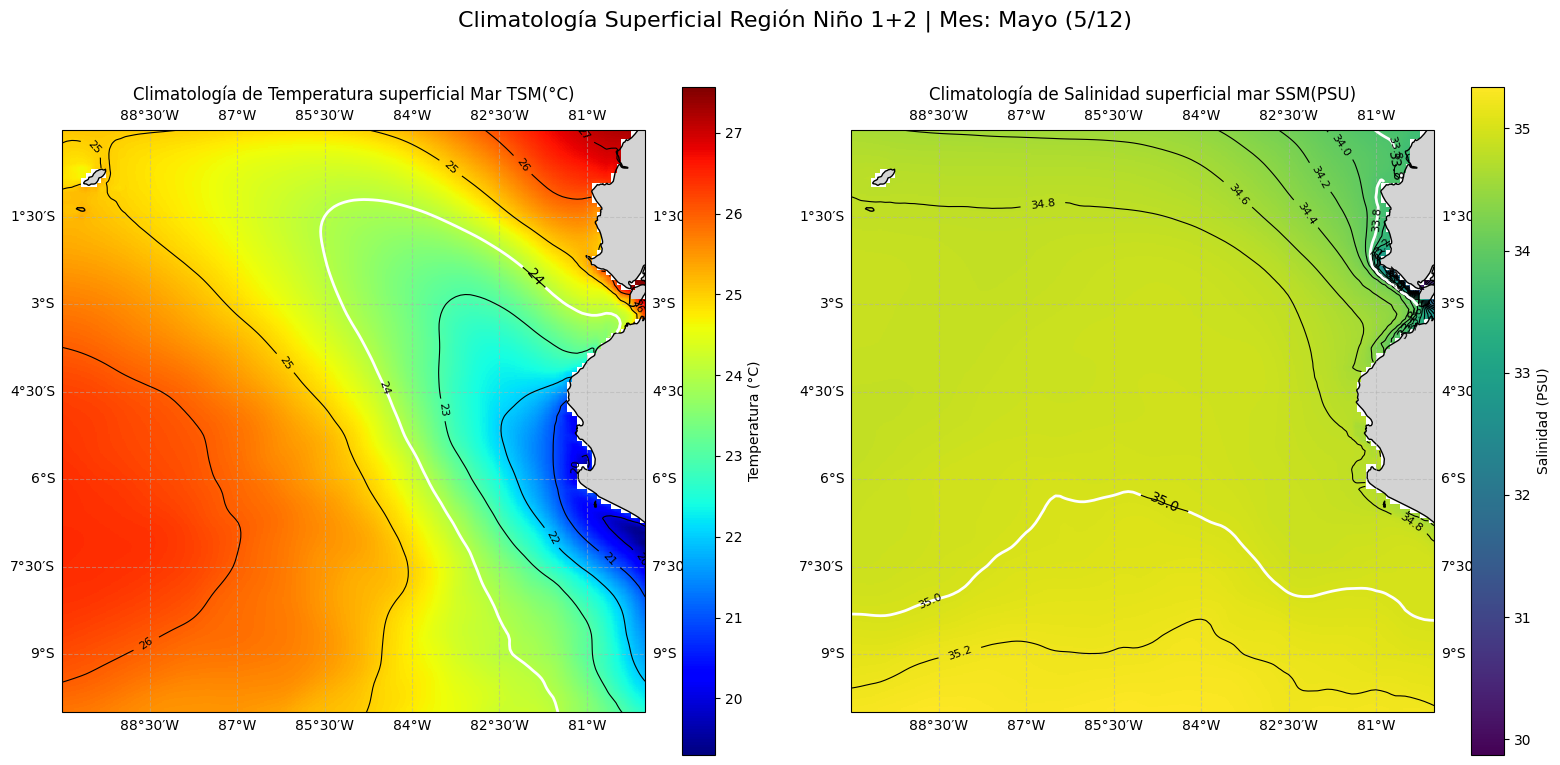

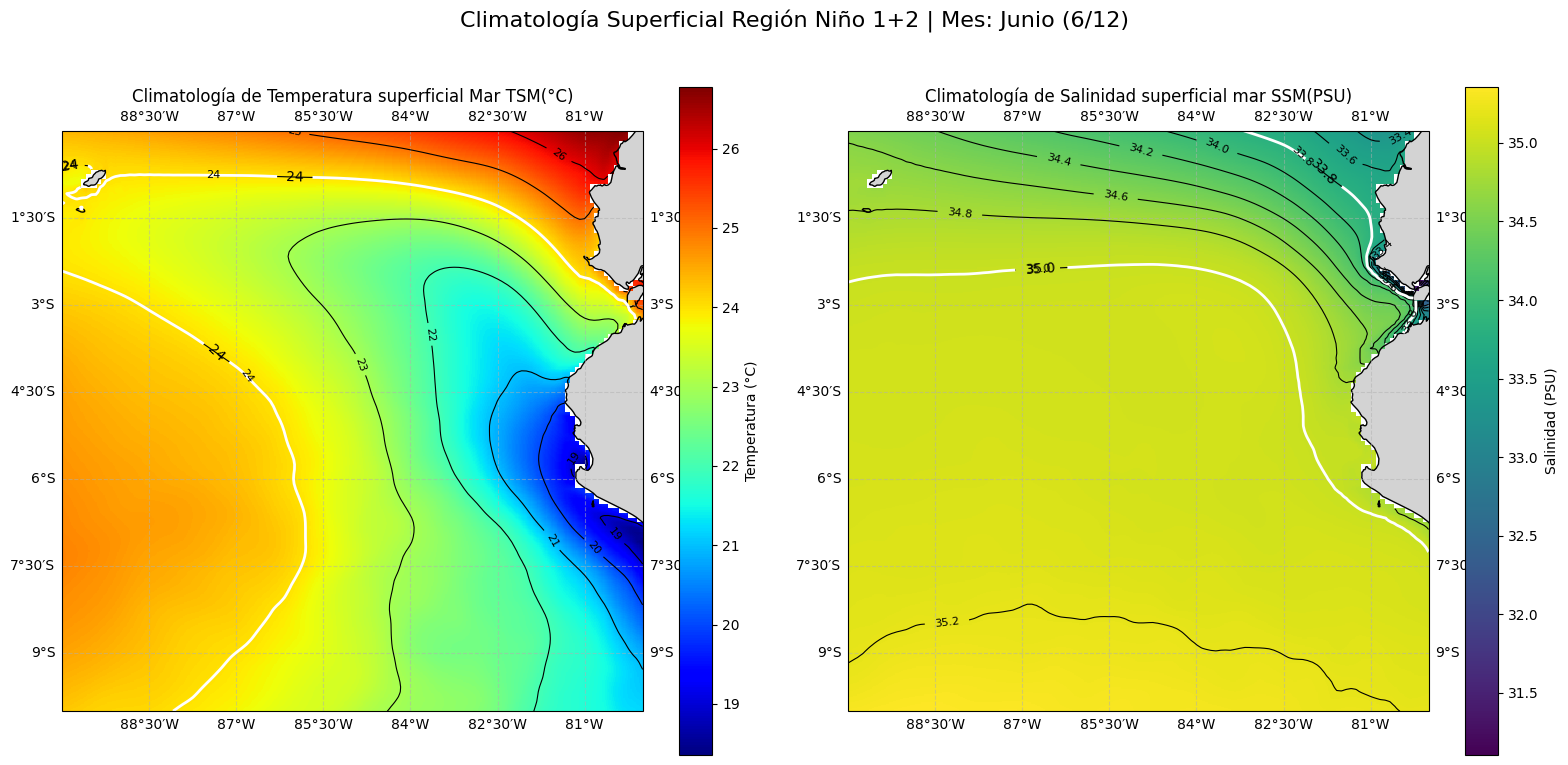

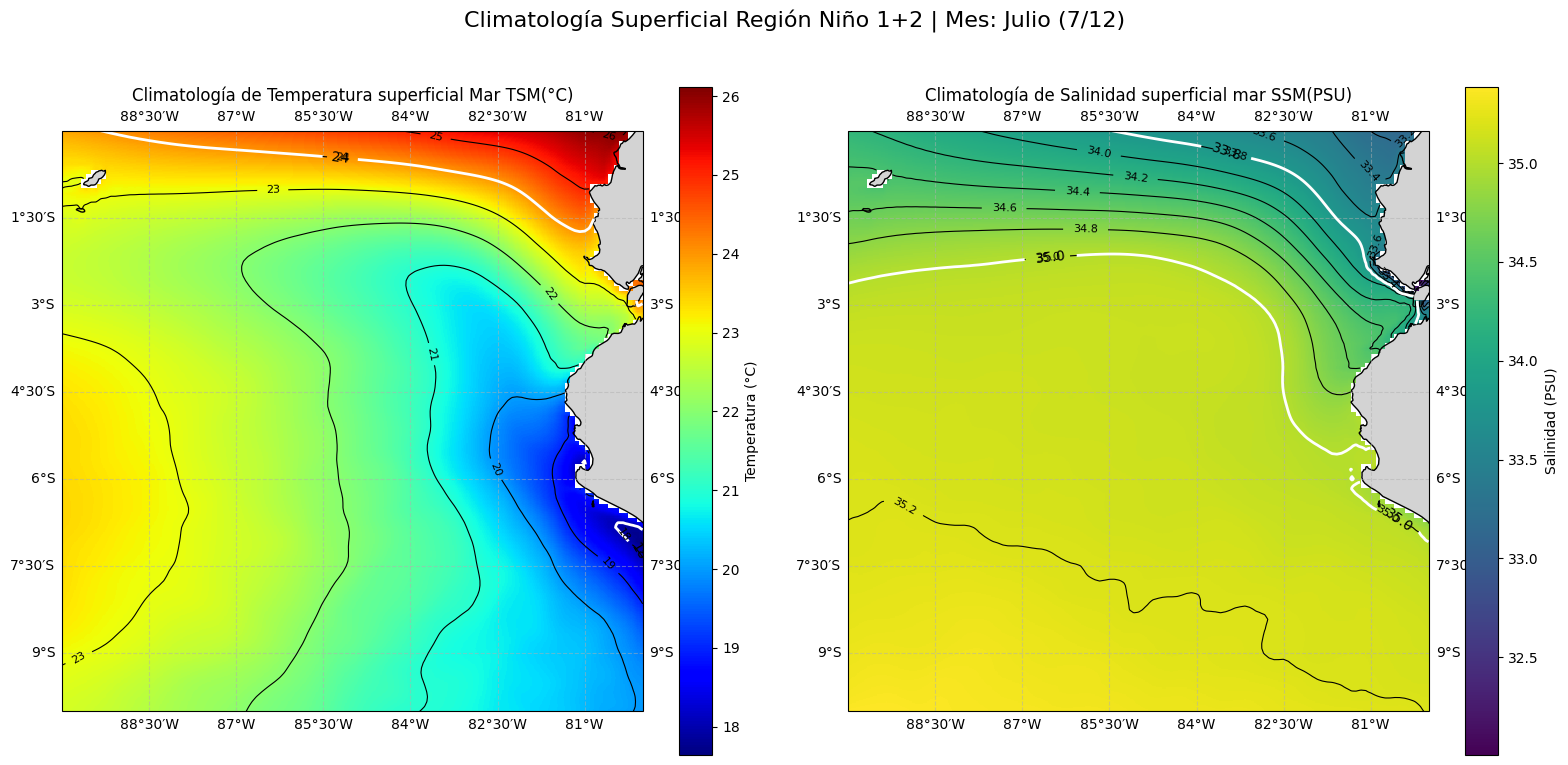

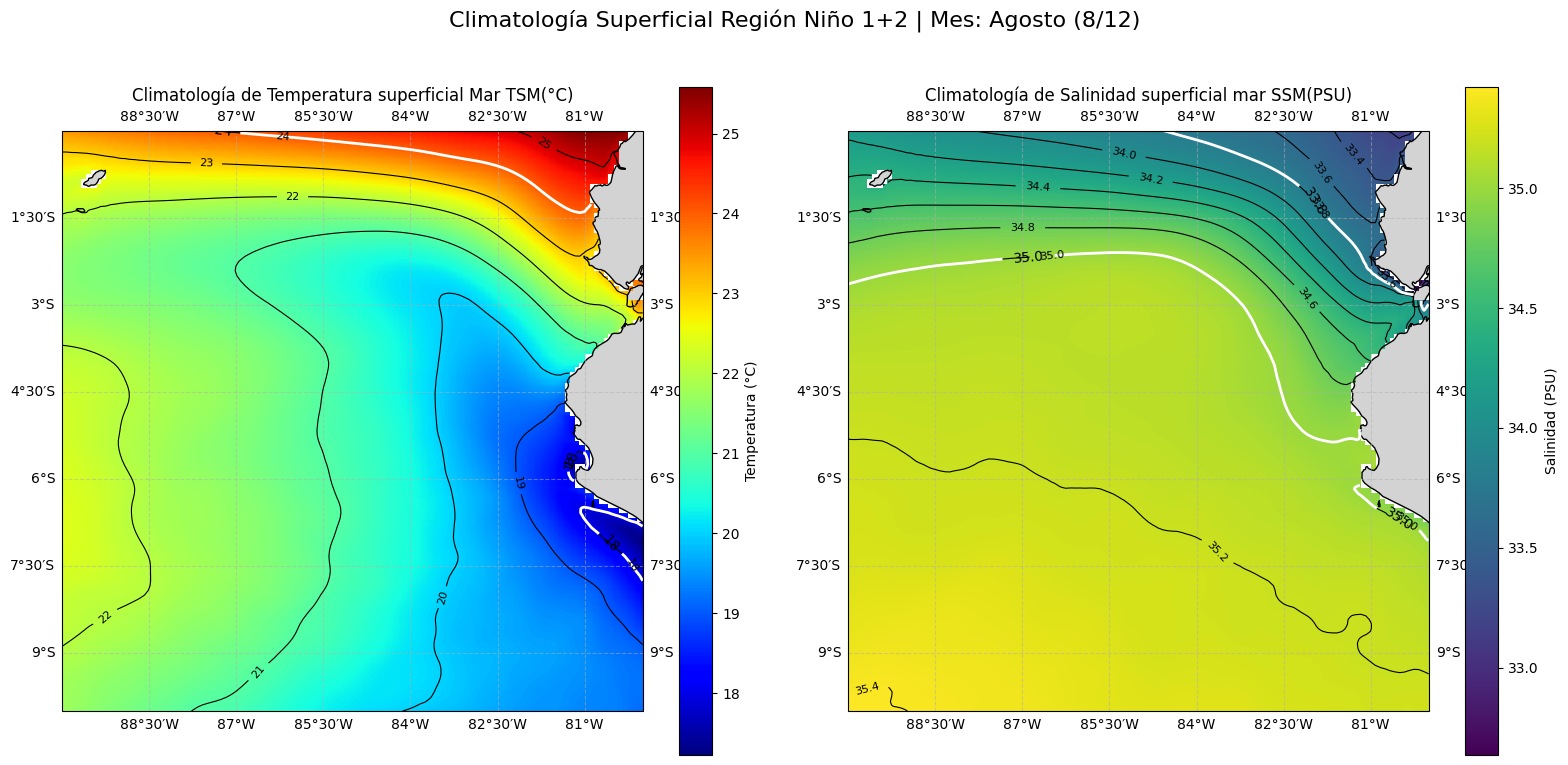

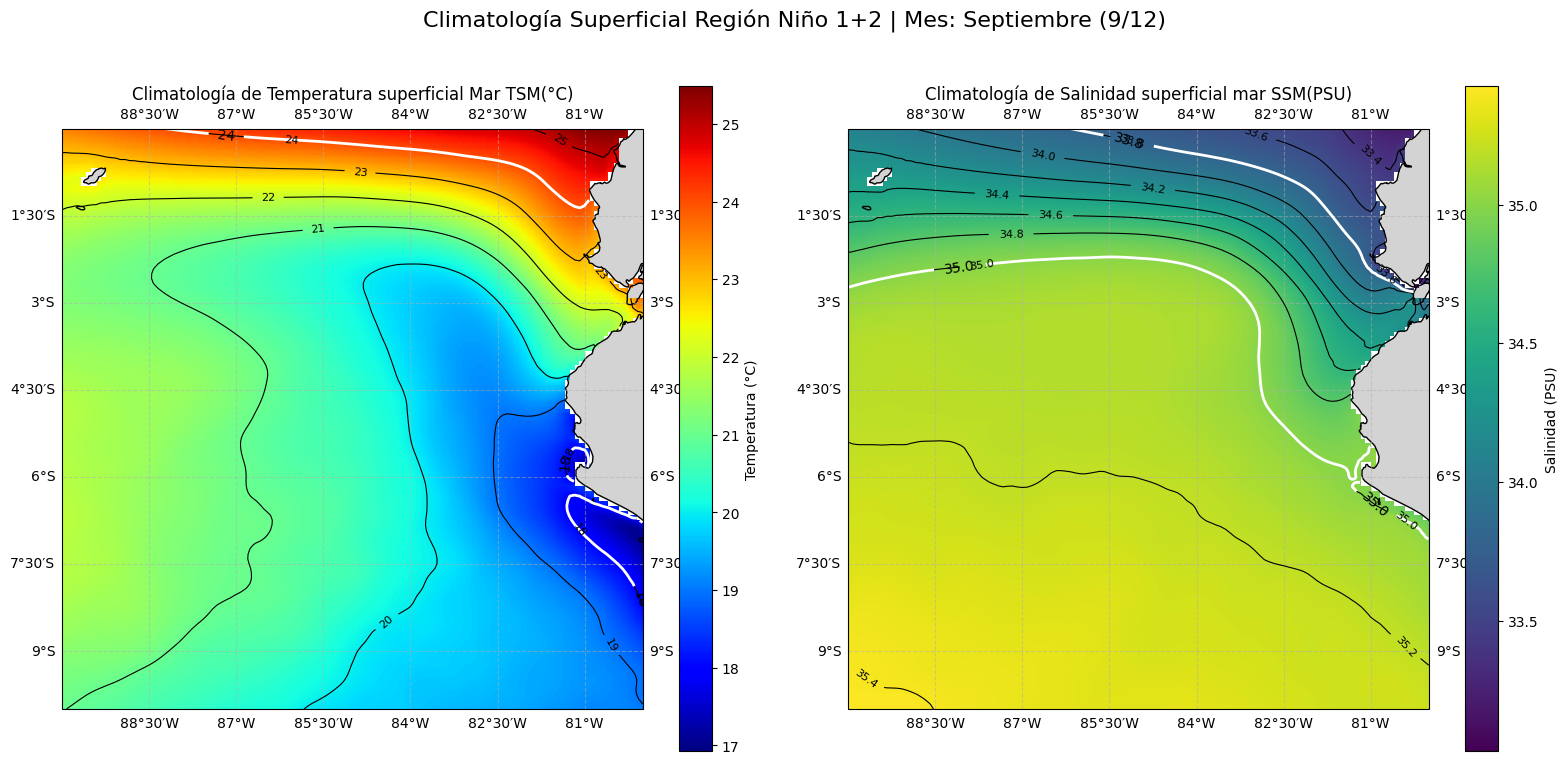

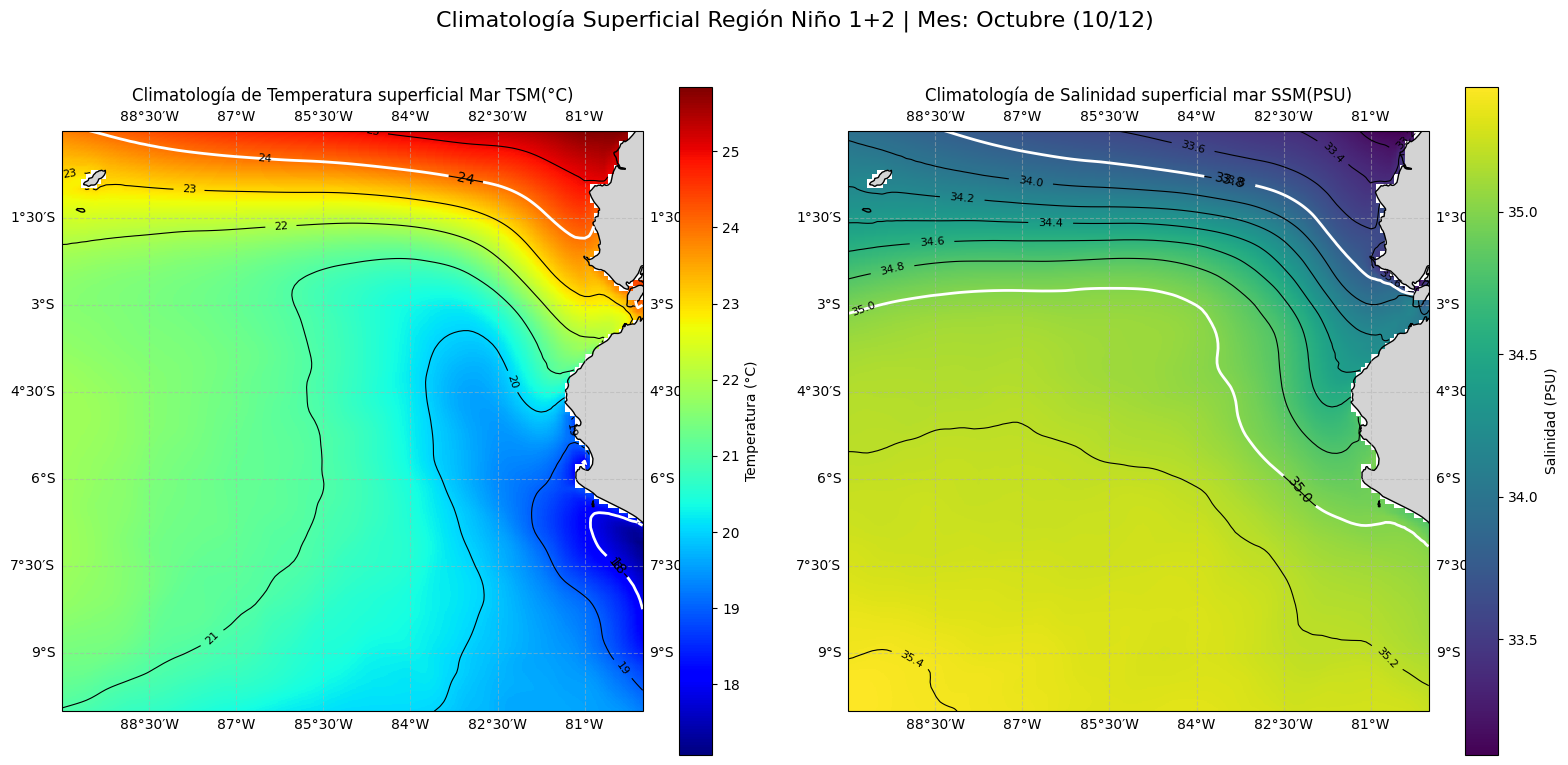

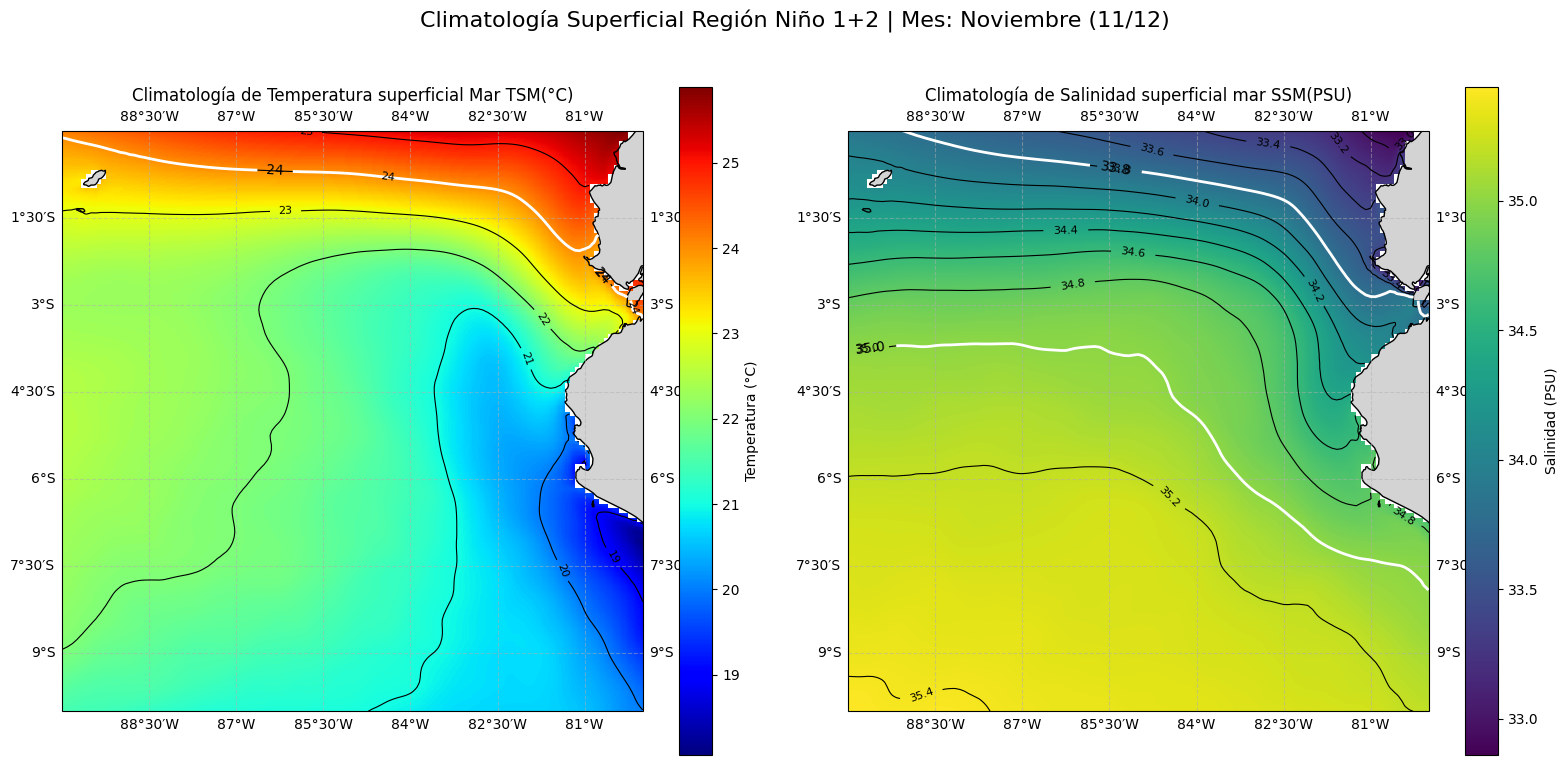

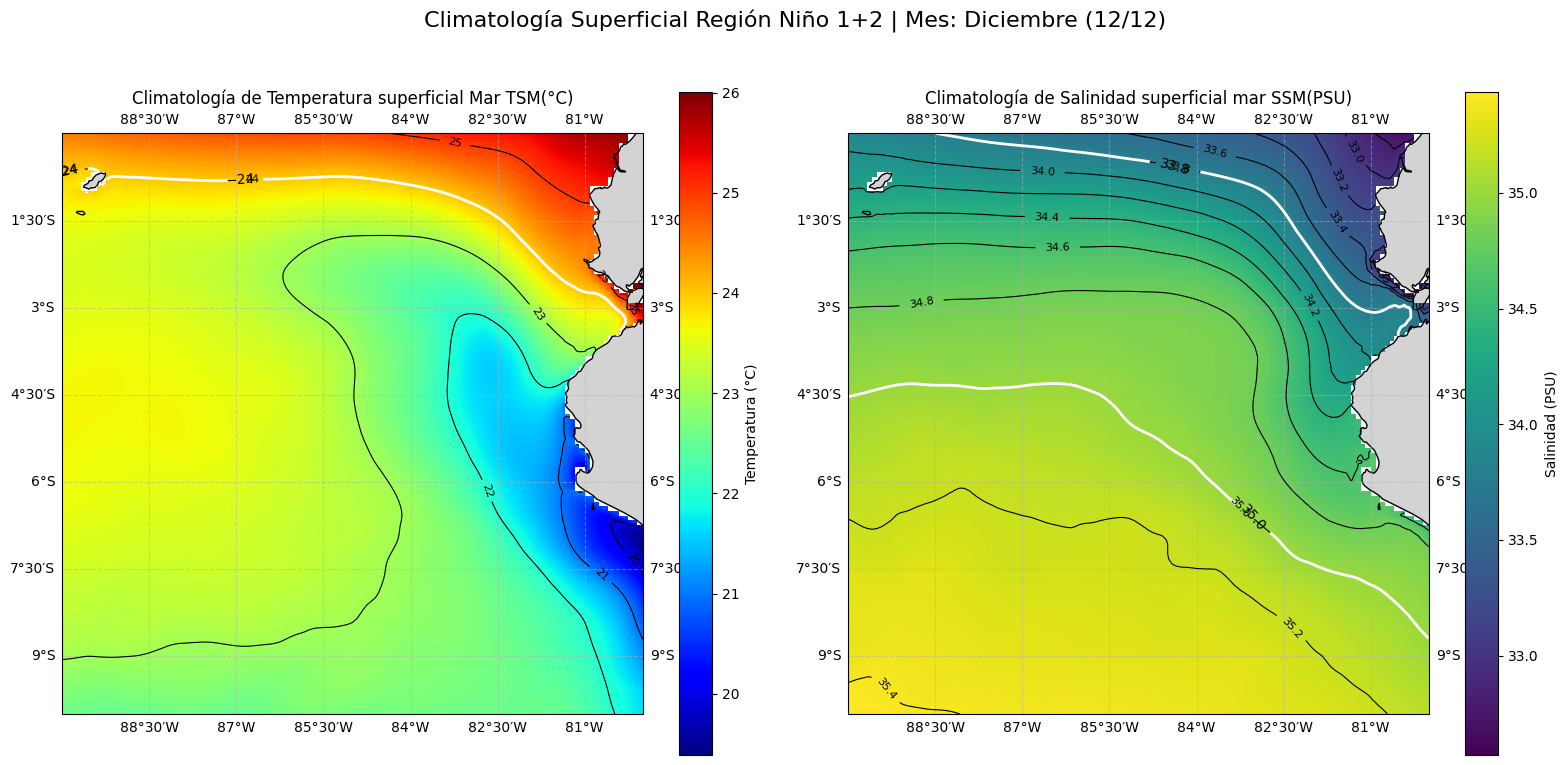

In [7]:
# Importamos la librería 'locale' para manejar el idioma (asegúrate de que esté al inicio del script)
import locale
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr


# --- CONFIGURACIÓN DE IDIOMA --- 
# Se necesita para asegurar que el nombre del mes en el nombre del archivo esté en español.
try:
    locale.setlocale(locale.LC_TIME, 'es_ES.utf8')
except locale.Error:
    try:
        locale.setlocale(locale.LC_TIME, 'Spanish')
    except locale.Error:
        print("Advertencia: No se pudo configurar el idioma español.")

# Definir los parámetros de visualización (tomado de tu código)
mapa_params = {
    'thetao': {
        'ax_index': 0, 
        'titulo_base': 'Temperatura superficial Mar TSM(°C)',
        'cmap': 'jet',
        'cbar_label': 'Temperatura (°C)',
        'niveles_contorno_paso': 1.0,
        'niveles_destacados': [18, 24]
    },
    'so': {
        'ax_index': 1,
        'titulo_base': 'Salinidad superficial mar SSM(PSU)',
        'cmap': 'viridis',
        'cbar_label': 'Salinidad (PSU)',
        'niveles_contorno_paso': 0.2,
        'niveles_destacados': [33.8, 35]
    }
}



# General bucle para los 12 meses 
for month_num in range(1, 13):

    # Configuración de la Figura con dos Subplots
    fig = plt.figure(figsize=(16, 8)) 
    
    # Crear dos subplots con la proyección PlateCarree
    axs = [
        fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree()), 
        fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())  
    ]
    
    # Bucle interno para Trazar Temperatura y Salinidad
    for variable_nombre, params in mapa_params.items():
        
        ax = axs[params['ax_index']]
        
        #Selección y Preparación de Datos (Asumiendo que ds_superficie_clima está cargado)
        da_superficie = ds_superficie_clima.sel(month=month_num)[variable_nombre]
        da_superficie = da_superficie.drop_duplicates(dim=['longitude', 'latitude'])

        #Definir y crear la nueva cuadrícula y límites
        lon_min = da_superficie.longitude.min().item()
        lon_max = da_superficie.longitude.max().item()
        lat_min = da_superficie.latitude.min().item()
        lat_max = da_superficie.latitude.max().item()
        new_lon = np.linspace(lon_min, lon_max, 500)
        new_lat = np.linspace(lat_min, lat_max, 500)

        #Aplicar interpolación
        da_superficie_interp = da_superficie.interp(longitude=new_lon, latitude=new_lat, method='slinear')
        
        
        #Configuración y Mapeo Geográfico
        ax.add_feature(cfeature.LAND, facecolor='lightgray')
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.set_extent([float(lon_min), float(lon_max), float(lat_min), float(lat_max)], crs=ccrs.PlateCarree())
        ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linestyle='--', alpha=0.5)


        #Mapeo de Colores (pcolormesh)
        p = da_superficie_interp.plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=params['cmap'],
            cbar_kwargs={'label': params['cbar_label'], 'orientation': 'vertical', 'pad': 0.05}
        )

        #Isolíneas Generales
        min_val = np.floor(da_superficie.min().item())
        max_val = np.ceil(da_superficie.max().item())
        paso_contorno = params['niveles_contorno_paso']
        niveles_contorno_general = np.arange(min_val, max_val + paso_contorno, paso_contorno)
        fmt_label = '%1.1f' if variable_nombre == 'so' else '%1.0f'
        
        contornos_general = da_superficie_interp.plot.contour(
            ax=ax, levels=niveles_contorno_general, colors='black', linewidths=0.8, transform=ccrs.PlateCarree()
        )
        ax.clabel(contornos_general, inline=True, fmt=fmt_label, fontsize=8, colors='black')

        
        #Isolíneas Destacadas (BLANCO)
        if params['niveles_destacados']:
            contornos_destacados = da_superficie_interp.plot.contour(
                ax=ax, levels=params['niveles_destacados'], colors='white', 
                linewidths=2.0, linestyles='solid', transform=ccrs.PlateCarree()
            )
            ax.clabel(contornos_destacados, inline=True, fmt=fmt_label, fontsize=10, colors='black')

        
        #Título del Subplot
        ax.set_title(f"Climatología de {params['titulo_base']}")
        
    
    # Título General de la Figura (Mes)
    nombre_mes = pd.to_datetime(month_num, format='%m').strftime('%B').title()
    titulo_general = f"Climatología Superficial Región Niño 1+2 | Mes: {nombre_mes} ({month_num}/12)"
    plt.suptitle(titulo_general, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el suptitle

    filename = f"Climatologia_Sup_{nombre_mes}_{month_num}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    
    # -----------------------------------------------
    plt.show() 
    plt.close(fig) 
    # Cerrar la figura para liberar memoria (¡CRUCIAL al generar muchos gráficos!)


________________________________________
## Análisis Climatológico Anual de la Superficie Marina (Región Niño 1+2)
    El ciclo anual en la Región Niño 1+2 está dominado por la oscilación entre la influencia de las aguas cálidas ecuatoriales (verano austral) y la lengua de agua fría de la Corriente de Humboldt (invierno austral), lo que define la posición de los frentes ecuatoriales de temperatura y salinidad.

### Temperatura Superficial del Mar (TSM): Ciclo de Calentamiento y Enfriamiento
    El año comienza con el periodo más cálido. El calentamiento se acelera en Enero y alcanza su pico anual en Febrero, con temperaturas que superan los 28 °C a 29 °C cerca de la costa, mientras que la influencia de las aguas frías del sur es mínima. Esta calidez persiste en Marzo, aunque el área de 27 °C ya comienza a contraerse ligeramente.

    La transición al enfriamiento se inicia en Abril, con una caída moderada de la TSM. Este enfriamiento se intensifica notablemente en Mayo, cuando el afloramiento costero de aguas frías se hace más evidente. La influencia fría domina en Junio y alcanza su máximo anual en Agosto y Septiembre, donde la TSM costera desciende hasta 18 °C a 19 °C, marcando la máxima extensión de la lengua de agua fría del Humboldt.

    El reinicio del calentamiento comienza en Octubre de manera paulatina. Se acelera en Noviembre y culmina en Diciembre, donde la TSM ya alcanza los 23 °C cerca de la costa, preparando el escenario para el retorno del pico cálido del verano.

### Salinidad Superficial del Mar (SSM): Ciclo de Desalinización y Salinización
    El ciclo de la salinidad está inversamente relacionado con el aporte de agua dulce (lluvias/ríos) y directamente con el afloramiento (ascenso de agua subsuperficial salada).

    El periodo de desalinización (baja salinidad) coincide con el verano y el máximo de escorrentía costera. Los valores caen en Enero y alcanzan su mínimo anual en Febrero y Marzo, con salinidades costeras inferiores a 33.0 PSU.

    La transición a la salinización se da a partir de Abril y se consolida en Mayo y Junio a medida que cesan las lluvias y el afloramiento se intensifica. El pico de alta salinidad se establece en Julio y Agosto, con valores superiores a 35.0 PSU mar adentro y >34.4 PSU en la costa, reflejando el máximo ascenso de agua salada subsuperficial y la ausencia de dilución fluvial.

    La transición de vuelta a la desalinización se observa en Octubre, se modera en Noviembre y se acelera en Diciembre, con una caída notable de la SSM, anticipando el gran aporte de agua dulce del siguiente verano.

### La Dinámica de los Frentes Ecuatoriales
    Los frentes actúan como los límites móviles de las masas de agua.

        1. Periodo de Avance (Ene-Mar): Durante el pico de verano, el Frente Ecuatorial de Temperatura (FET) y el Frente Ecuatorial de Salinidad (FES) avanzan hacia el sur y hacia la costa. El FET se debilita por la TSM alta en toda la región, y el FES se retira al oeste al ser reemplazado por aguas poco salinas. Este es el periodo de dominancia de la masa de agua ecuatorial.

        2. Periodo de Retracción (Jul-Sep): Durante el pico de invierno, la intensificación de la Corriente de Humboldt fuerza a los frentes a la máxima retracción (se mueven al norte y al oeste). El FET se vuelve muy fuerte y se posiciona en las latitudes más septentrionales (cerca de 1° S), marcando un contraste térmico agudo. El FES se ubica en las mismas latitudes, delimitando las aguas 35.0 PSU del sur de las aguas oceánicas menos saladas del norte. Este es el periodo de dominancia de la masa de agua fría costera.

    La migración anual de estos frentes define la variabilidad climática, oceanográfica y biológica de la Región Niño 1+2.

________________________________________


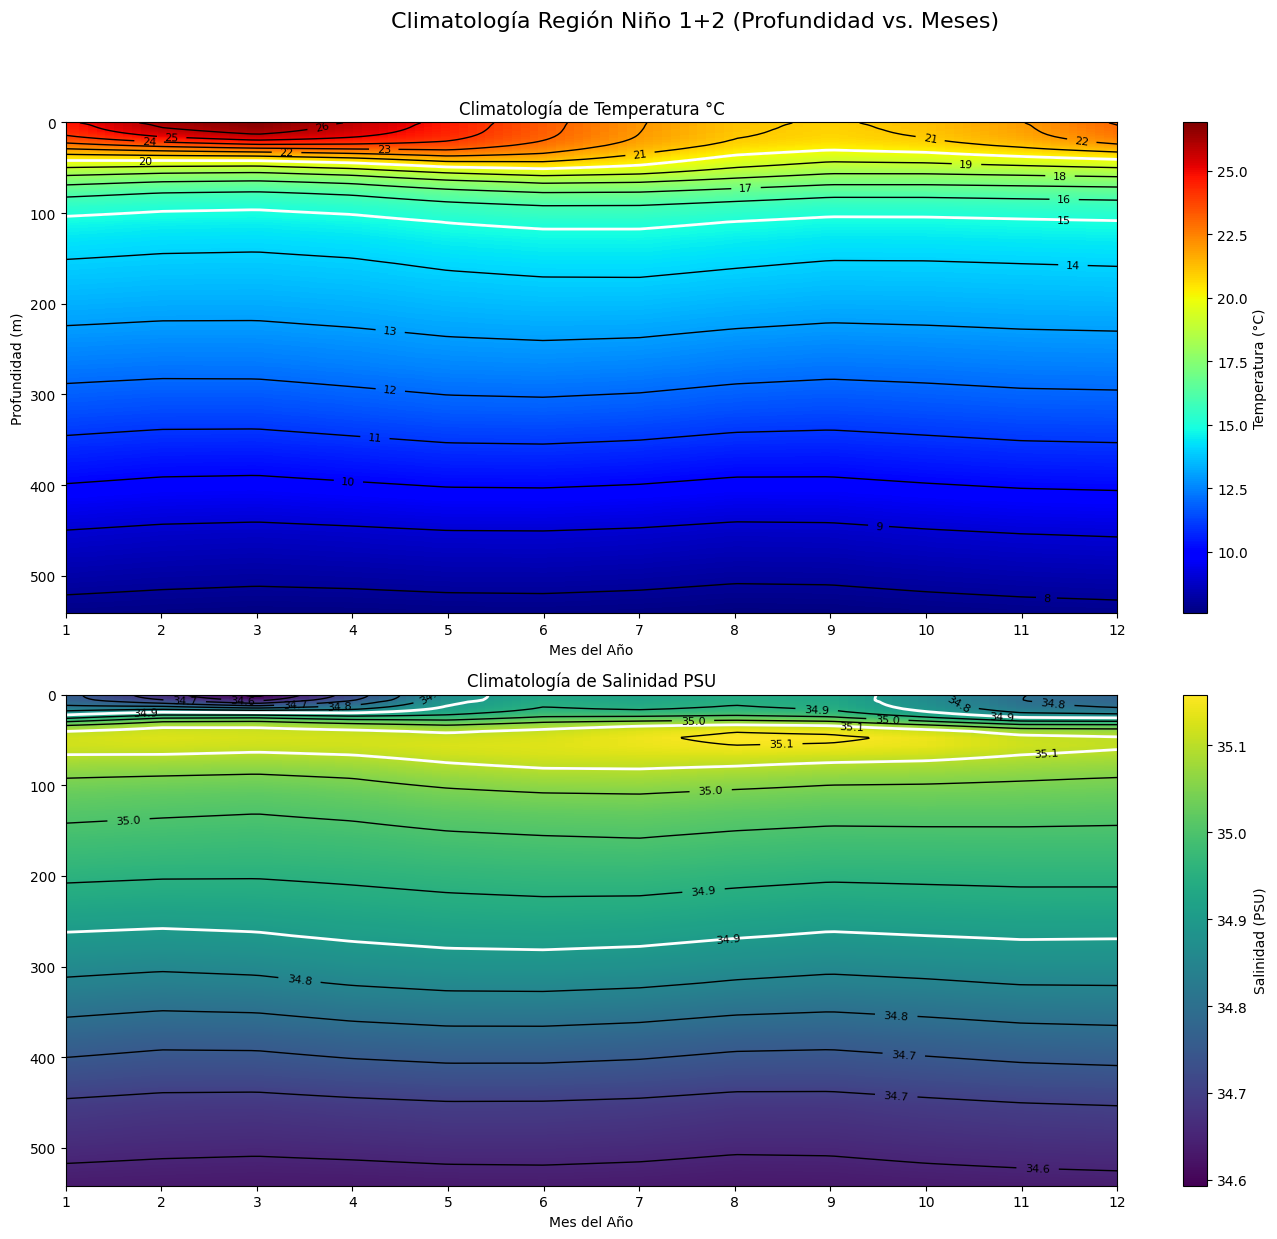

In [8]:
#------- Perfil de climatologia profundidad vs meses para Temperatura y Salinidad de la Región Niño 1+2----------------
#Definir la nueva cuadrícula (Meses y Profundidad)

meses_min, meses_max = ds_corte_clima.month.min().item(), ds_corte_clima.month.max().item()
new_months = np.linspace(meses_min, meses_max, 120) # 120 puntos para meses (X)

prof_min, prof_max = ds_corte_clima.depth.min().item(), ds_corte_clima.depth.max().item()
new_depth = np.linspace(prof_min, prof_max, 500) # 500 puntos para profundidad (Y)

#Aplicar interpolación 2D
ds_corte_clima_interp = ds_corte_clima.interp(month=new_months, depth=new_depth, method='slinear')

#Crear Subplots de temperatura y salinidad
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(14,13), sharey=True
)

#Gráfico de Temperatura
p1 = ds_corte_clima_interp['thetao'].plot.pcolormesh(
    ax=ax1,
    x='month',
    y='depth',
    yincrease=False,
    cmap='jet',
    cbar_kwargs={'label': 'Temperatura (°C)', 'orientation': 'vertical', 'pad': 0.05}
)
#Añadir isolíneas
contornos_t = ds_corte_clima_interp['thetao'].plot.contour(
    ax=ax1,
    x='month',
    y='depth',
    yincrease=False,
    levels=np.arange(np.floor(ds_corte_clima['thetao'].min().item()), np.ceil(ds_corte_clima['thetao'].max().item()) + 1, 1),
    colors='black',
    linewidths=1.0
)
ax1.clabel(contornos_t, inline=True, fmt='%1.0f', fontsize=8, colors='black')
#Niveles para la termoclina
temp_niveles_termoclina = [15, 20]
#Trazar isolíneas termoclina
contornos_termoclina = ds_corte_clima_interp['thetao'].plot.contour(
    ax=ax1,
    x='month',
    y='depth',
    yincrease=False,
    levels=temp_niveles_termoclina,
    colors='white',
    linewidths=2.0,
    linestyles='solid'
)

ax1.set_title('Climatología de Temperatura °C')
ax1.set_xlabel('Mes del Año')
ax1.set_ylabel('Profundidad (m)')
ax1.set_xticks(range(1, 13))
ax1.set_xlim(1, 12) 


#Gráfico de Salinidad 
p2 = ds_corte_clima_interp['so'].plot.pcolormesh(
    ax=ax2,
    x='month',
    y='depth',
    yincrease=False,
    cmap='viridis',
    cbar_kwargs={'label': 'Salinidad (PSU)', 'orientation': 'vertical', 'pad': 0.05}
)
# Añadir isolíneas
contornos_s = ds_corte_clima_interp['so'].plot.contour(
    ax=ax2,
    x='month',
    y='depth',
    yincrease=False,
    levels=np.arange(np.floor(ds_corte_clima['so'].min().item() * 10) / 10, np.ceil(ds_corte_clima['so'].max().item() * 10) / 10 + 0.05, 0.05),
    colors='black',
    linewidths=1.0
)
ax2.clabel(contornos_s, inline=True, fmt='%1.1f', fontsize=8, colors='black')
#Niveles para la haloclina
sali_niveles_haloclina = [34.9, 35.1]
#Trazar isolíneas termoclina
contornos_haloclina = ds_corte_clima_interp['so'].plot.contour(
    ax=ax2,
    x='month',
    y='depth',
    yincrease=False,
    levels=sali_niveles_haloclina,
    colors='white',
    linewidths=2.0,
    linestyles='solid'
)

ax2.set_title('Climatología de Salinidad PSU')
ax2.set_xlabel('Mes del Año')
ax2.set_ylabel('')
ax2.set_xticks(range(1, 13))
ax2.set_xlim(1, 12) 

plt.suptitle('Climatología Región Niño 1+2 (Profundidad vs. Meses)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

filename = "Climatologia_Corte_Vertical_Nino_1+2.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show() 
plt.close(fig) 

_______________________________
## Análisis Climatológico de Corte Vertical (Región Niño 1+2)
    La gráfica muestra el ciclo anual de la estructura de la columna de agua en la Región Niño 1+2, dominado por la pulsación de la termoclina y la haloclina.

        1. Climatología de Temperatura: Pico cálido (Feb-Mar) la TSM supera los 28 °C. La capa cálida es más gruesa, y la termoclina se encuentra profunda (≈40 a 50 m para la isoterma 20 °C); mentras que su pico Frío (Jul-Sep) la TSM cae a <21 °C. El afloramiento intenso hace que la termoclina sea somera y se eleve (≈30 a 45 m para la isoterma 20 °C).

        2. Climatología de Salinidad (PSU): Mínima salinidad (Feb-Mar) la capa superficial es menos salada (<33.0 PSU), debido a la escorrentía fluvial. La capa de máxima salinidad (35.1 PSU) se encuentra profunda; por su parte la máxima salinidad (Jul-Sep) la capa superficial es más salada (>35.0 PSU). El afloramiento eleva la capa subsuperficial salada (Núcleo de Agua Subtropical) cerca de la superficie, confirmando la intrusión de agua fría y salada.

### Conclusión
    La climatología vertical evidencia la alternancia estacional entre una columna de agua cálida y desalinizada con termoclina profunda (Verano: Feb-Mar) y una columna de agua fría y salinizada con termoclina somera (Invierno: Jul-Sep), característica del régimen de afloramiento y de la influencia anual de la Corriente de Humboldt.
_________________________________________

In [4]:
import os
import nbformat 
from nbconvert import HTMLExporter
from traitlets.config import Config
from IPython.display import clear_output
import weasyprint  # <-- 1. Importamos la nueva librería

# --- CONFIGURACIÓN ---
notebook_path = "ClimatologiaRegion1+2.ipynb"
output_html_filename = "Informe_Climatologia.html"
output_pdf_filename = "Informe_Climatologia.pdf" # <-- 2. Definimos el nombre del PDF

def force_save_notebook(path):
    """
    Abre y reescribe el Notebook para forzar que el sistema de archivos 
    guarde el estado actual (incluyendo outputs y la limpieza realizada).
    """
    try:
        with open(path, 'r', encoding='utf-8') as f:
            nb = nbformat.read(f, as_version=4)
        with open(path, 'w', encoding='utf-8') as f:
            nbformat.write(nb, f)
        print(f"-> Notebook '{path}' guardado con éxito.")
        return True
    except Exception as e:
        print(f"Error al forzar el guardado del Notebook: {e}")
        return False

# --- PASO 1: GENERAR EL ARCHIVO HTML (Tu código actual) ---
print("Iniciando el proceso de generación de informes...")

if not force_save_notebook(notebook_path):
    exit()

try:
    c = Config()
    c.HTMLExporter.exclude_input = True
    c.HTMLExporter.exclude_markdown = False
    
    html_exporter = HTMLExporter(config=c)
    
    output, resources = html_exporter.from_filename(notebook_path)
    
    with open(output_html_filename, 'w', encoding='utf-8') as f:
        f.write(output)
    
    print(f"-> ¡Informe HTML '{output_html_filename}' creado exitosamente!")

except Exception as e:
    print(f"Ocurrió un error durante la conversión a HTML: {e}")
    exit() # Si el HTML falla, no continuamos

# --- PASO 2: CONVERTIR EL HTML A PDF (Nueva sección) ---
try:
    print(f"\nConvirtiendo '{output_html_filename}' a PDF...")
    
    # Se crea un objeto HTML con WeasyPrint a partir del archivo generado
    html_file = weasyprint.HTML(filename=output_html_filename)
    
    # Se renderiza y escribe el PDF en el disco
    html_file.write_pdf(output_pdf_filename)
    
    print(f"-> ¡Informe PDF '{output_pdf_filename}' creado exitosamente!")

except Exception as e:
    print(f"Ocurrió un error durante la conversión a PDF: {e}")

clear_output()
print("\n¡Proceso finalizado! ✨")


¡Proceso finalizado! ✨
